In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
%matplotlib inline

### PRE-PROCESSING

In [2]:
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)
df.head()

FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10

In [3]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
df_orig = df.copy()
df.head()

FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday

In [4]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

df['LABEL'] = df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df = df.drop('STAT_CAUSE_DESCR',axis=1)
df = df.drop('DATE',axis=1)

In [5]:
df.head()

FIRE_YEAR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
0       2005  40.036944 -121.005833    CA       2453403.5       0.10      2   
1       2004  38.933056 -120.404444    CA       2453137.5       0.25      5   
2       2004  38.984167 -120.735556    CA       2453156.5       0.10      5   
3       2004  38.559167 -119.913333    CA       2453184.5       0.10      6   
4       2004  38.559167 -119.933056    CA       2453184.5       0.10      6   

  DAY_OF_WEEK  LABEL  
0   Wednesday      4  
1   Wednesday      1  
2      Monday      2  
3      Monday      1  
4      Monday      1

In [6]:
le = preprocessing.LabelEncoder()
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])

df = df.dropna()

X = df.drop(['LABEL'], axis=1).values
Y = df['LABEL'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [7]:
def show_confusion_matrix(cm):
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(4)
    fig,ax = plt.subplots(figsize=(5,5))
    ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

### PCA

In [8]:
features = df[['LATITUDE', 'LONGITUDE', 'STATE', 'FIRE_SIZE', 'DAY_OF_WEEK', 'MONTH']].astype(float)
scaler = StandardScaler()
scaler.fit(features)
scaled_data = scaler.transform(features)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

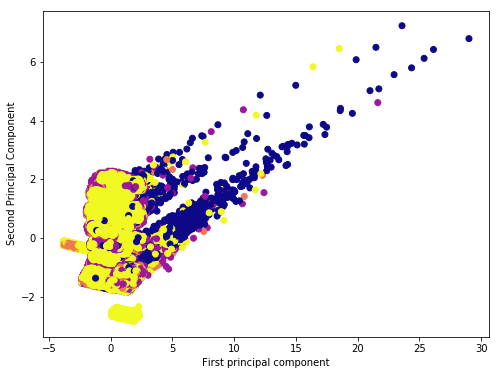

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['LABEL'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()

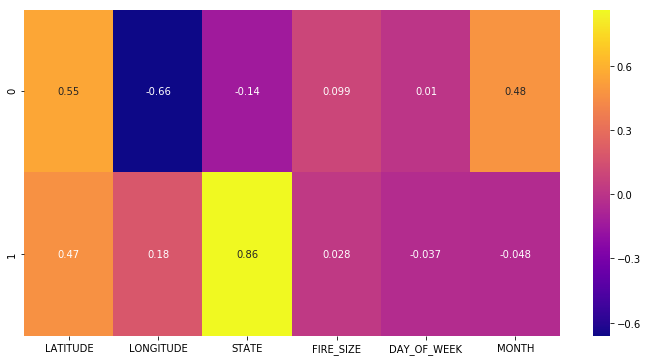

In [11]:
df_comp = pd.DataFrame(pca.components_,columns=['LATITUDE', 'LONGITUDE', 'STATE', 'FIRE_SIZE', 'DAY_OF_WEEK', 'MONTH'])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma', annot=True)


### Logistic Regression

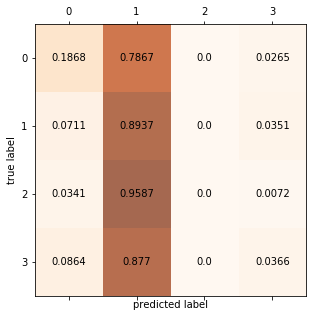

              precision    recall  f1-score   support

           1       0.32      0.19      0.24     55598
           2       0.45      0.89      0.60    166019
           3       0.00      0.00      0.00     56326
           4       0.32      0.04      0.07     98150

   micro avg       0.43      0.43      0.43    376093
   macro avg       0.27      0.28      0.22    376093
weighted avg       0.33      0.43      0.31    376093



In [12]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=100)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
cm = confusion_matrix(y_test,predictions)
show_confusion_matrix(cm)
print(classification_report(y_test,predictions))

In [13]:
print(logmodel.score(X_test, y_test).round(4))

0.4317


### DECISION TREES

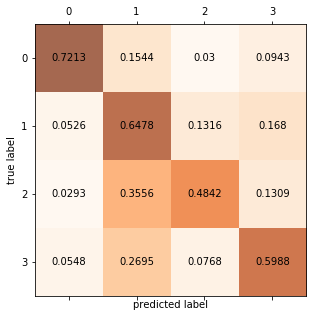

              precision    recall  f1-score   support

           1       0.72      0.72      0.72     55598
           2       0.66      0.65      0.65    166019
           3       0.47      0.48      0.48     56326
           4       0.59      0.60      0.60     98150

   micro avg       0.62      0.62      0.62    376093
   macro avg       0.61      0.61      0.61    376093
weighted avg       0.62      0.62      0.62    376093



In [14]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
cm = confusion_matrix(y_test,predictions)
show_confusion_matrix(cm)
print(classification_report(y_test,predictions))

In [15]:
print(dtree.score(X_test, y_test).round(4))

0.6214


### RANDOM FOREST

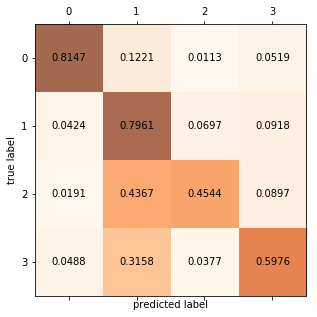

              precision    recall  f1-score   support

           1       0.78      0.81      0.80     55598
           2       0.68      0.80      0.73    166019
           3       0.62      0.45      0.52     56326
           4       0.72      0.60      0.65     98150

   micro avg       0.70      0.70      0.70    376093
   macro avg       0.70      0.67      0.68    376093
weighted avg       0.69      0.70      0.69    376093



In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
cm = confusion_matrix(y_test,predictions)
show_confusion_matrix(cm)
print(classification_report(y_test,predictions))

In [17]:
print(rfc.score(X_test, y_test).round(4))

0.6959


### NEURAL NETWORKS

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=50, alpha=1e-4,
                    solver='adam', verbose=0, tol=1e-8, random_state=1,
                    learning_rate_init=.01)
mlp.fit(X_train, y_train)

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.plot(mlp.loss_curve_)
plt.show()

predictions = mlp.predict(X_test)
cm = confusion_matrix(y_test,predictions)
show_confusion_matrix(cm)
print(classification_report(y_test,predictions))

In [ ]:
print(mlp.score(X_test, y_test).round(4))

### SVM

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(gamma='auto')
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)
cm = confusion_matrix(y_test,predictions)
show_confusion_matrix(cm)
print(classification_report(y_test,predictions))

In [ ]:
print(svc_model.score(X_test, y_test).round(4))